左足マーカー数: 1
右足マーカー数: 1


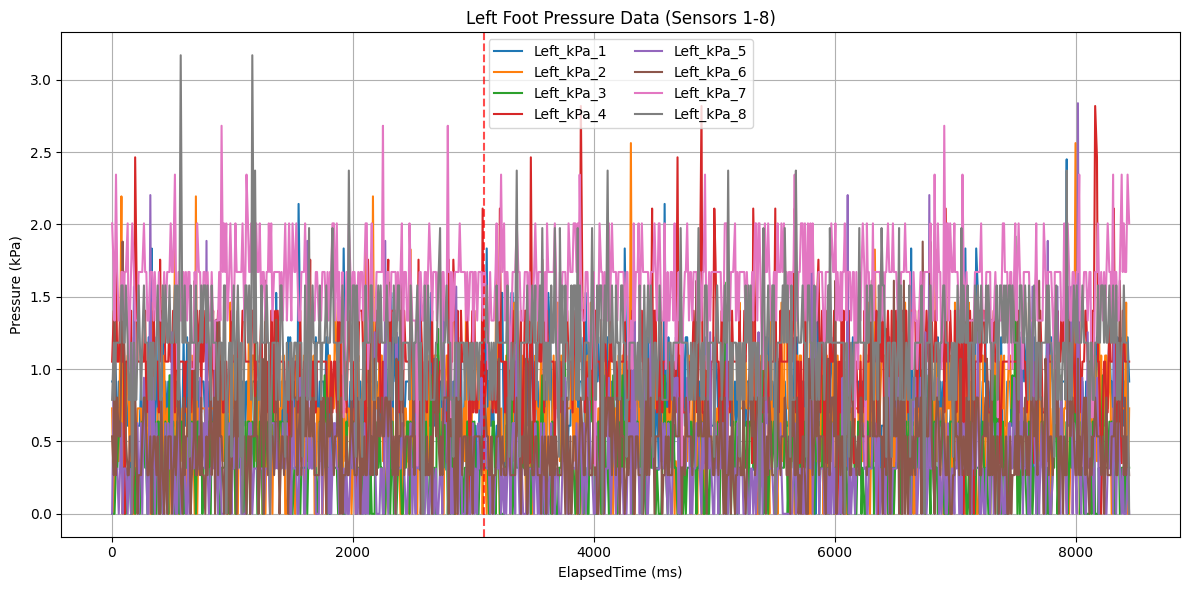

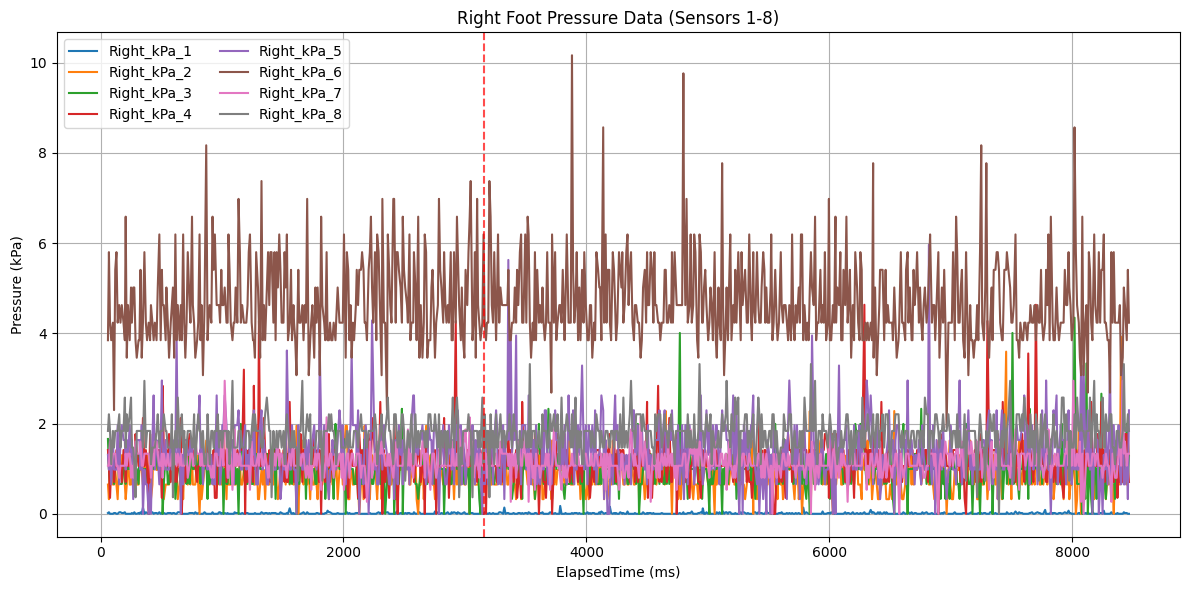

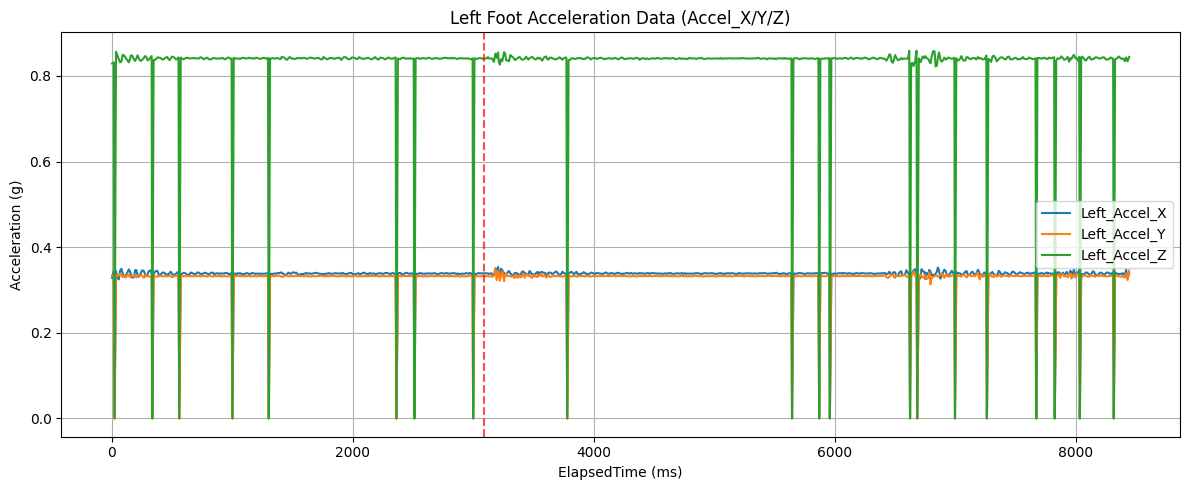

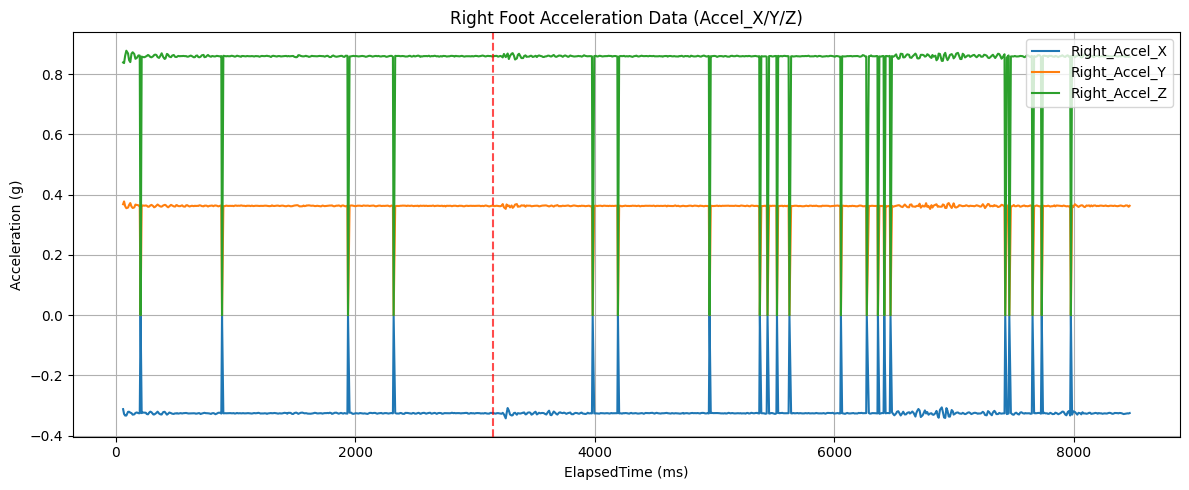

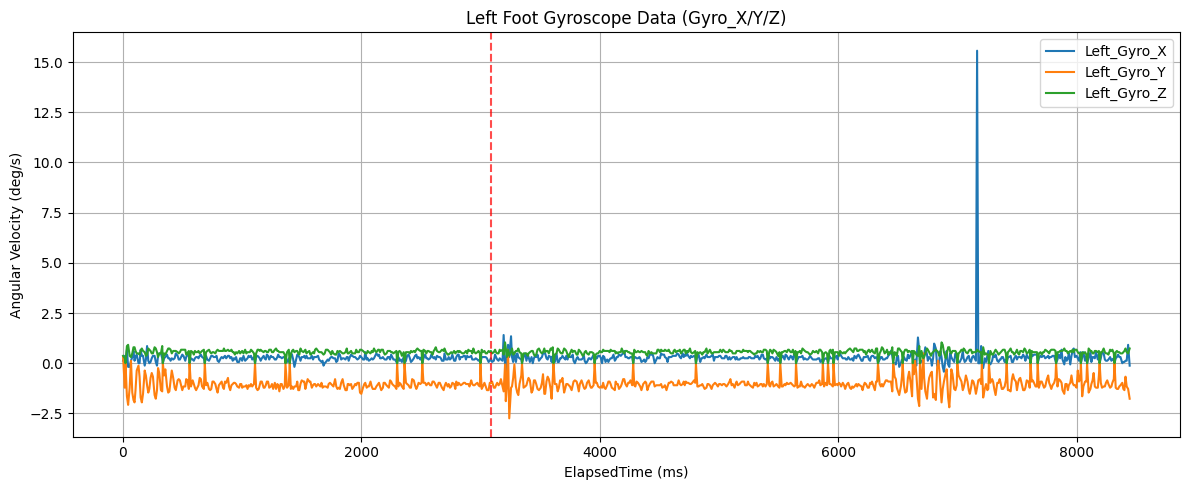

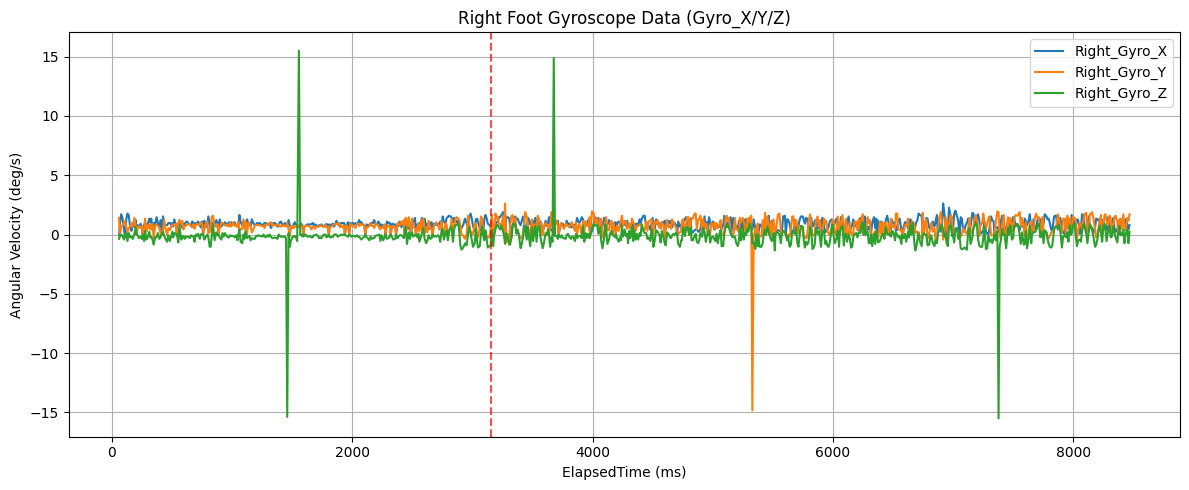

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルを読み込む
left_filename = "left_foot_data_imu.csv"
df_left = pd.read_csv(left_filename)
right_filename = "right_foot_data_imu.csv"
df_right = pd.read_csv(right_filename)

# 横軸：ElapsedTime
time_left = df_left['ElapsedTime']
time_right = df_right['ElapsedTime']

# マーカーが記録されている時刻を取得（0でない，かつNaNでない行）
marker_times_left = df_left[(df_left['Marker'].notna()) & (df_left['Marker'] != 0)]['ElapsedTime']
marker_times_right = df_right[(df_right['Marker'].notna()) & (df_right['Marker'] != 0)]['ElapsedTime']

print(f"左足マーカー数: {len(marker_times_left)}")
print(f"右足マーカー数: {len(marker_times_right)}")

# 1. 足圧センサーデータ（kPa_1～8）- 左足
kpa_cols = ['kPa_1', 'kPa_2', 'kPa_3', 'kPa_4', 'kPa_5', 'kPa_6', 'kPa_7', 'kPa_8']

plt.figure(figsize=(12, 6))
for col in kpa_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Pressure (kPa)')
plt.title('Left Foot Pressure Data (Sensors 1-8)')
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# 1. 足圧センサーデータ（kPa_1～8）- 右足
plt.figure(figsize=(12, 6))
for col in kpa_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Pressure (kPa)')
plt.title('Right Foot Pressure Data (Sensors 1-8)')
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 加速度データ - 左足
accel_cols = ['Accel_X', 'Accel_Y', 'Accel_Z']

plt.figure(figsize=(12, 5))
for col in accel_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Acceleration (g)')
plt.title('Left Foot Acceleration Data (Accel_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 加速度データ - 右足
plt.figure(figsize=(12, 5))
for col in accel_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Acceleration (g)')
plt.title('Right Foot Acceleration Data (Accel_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 角速度データ - 左足
gyro_cols = ['Gyro_X', 'Gyro_Y', 'Gyro_Z']

plt.figure(figsize=(12, 5))
for col in gyro_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Angular Velocity (deg/s)')
plt.title('Left Foot Gyroscope Data (Gyro_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 角速度データ - 右足
plt.figure(figsize=(12, 5))
for col in gyro_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Angular Velocity (deg/s)')
plt.title('Right Foot Gyroscope Data (Gyro_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()